# Using LayeredPlanarBiaxial

In [1]:
import pymecht as pmt
from matplotlib import pyplot as plt
import numpy as np

We start by creating two `PlanarBiaxialExtension` samples with different material properties and different **reference length**. We also set the fiber directions for the two layers differently.

In [2]:
mat1 = pmt.MatModel('nh','goh')
strip_1 = pmt.PlanarBiaxialExtension(mat1,disp_measure='length', force_measure='force')
pmt.specify_two_fibers(strip_1,45)
params = strip_1.parameters
params.set('mu_0',22.57)
params.set('k1_1',276.45)
params.set('k2_1',42.85)
params.set('k3_1',0.246)
params.set('L10',20)
params.set('L20',21)
strip_1.parameters = params

mat2 = pmt.MatModel('nh','goh')
strip_2 = pmt.PlanarBiaxialExtension(mat2,disp_measure='length', force_measure='force')
pmt.specify_two_fibers(strip_2,30)
params = strip_2.parameters
params.set('mu_0',14.30)
params.set('k1_1',290.22)
params.set('k2_1',4.87)
params.set('k3_1',0.224)
params.set('L10',22)
params.set('L20',22)
strip_2.parameters = params

Fiber directions set to  45  degrees ( 0.7853981633974483  radians)
Fiber directions set to  30  degrees ( 0.5235987755982988  radians)


Next, we combine them using `LayeredPlanarBiaxial` and check its parameters. We notice that all the parameters for the first "layer" have `_layer0` appended to their names, and those for second layer have `_layer1` appended, etc.

In [3]:
combined = pmt.LayeredPlanarBiaxial(strip_1,strip_2)
print(combined.parameters)

------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
L10_layer0        20.00       No          1.00e-04    1.00e+03    
L20_layer0        21.00       No          1.00e-04    1.00e+03    
thick_layer0      1.00        No          1.00e-04    1.00e+03    
mu_0_layer0       22.57       No          1.00e-04    1.00e+02    
k1_1_layer0       2.76e+02    No          0.10        30.00       
k2_1_layer0       42.85       No          0.10        30.00       
k3_1_layer0       0.25        No          0.00        0.33        
L10_layer1        22.00       No          1.00e-04    1.00e+03    
L20_layer1        22.00       No          1.00e-04    1.00e+03    
thick_layer1      1.00        No          1.00e-04    1.00e+03    
mu_0_layer1       14.30       No          1.00e-04    1.00e+02    
k1_1_layer1       2.90e+02    No          0.10        30.00   

We impose a deformed length varying between 20 and 25 and calculate and plot the resulting forces along the two axes.

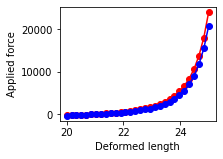

In [4]:
def_length1 = np.linspace(20,25,30)
def_length2 = np.linspace(20,25,30)
def_length = np.vstack((def_length1,def_length2)).T
force = combined.disp_controlled(def_length)

fig,ax = plt.subplots(1,1,figsize=(4*0.7,3*0.7))
ax.plot(def_length[:,0],force[:,0],'-o',color='r',label='x')
ax.plot(def_length[:,1],force[:,1],'-o',color='b',label='y')
ax.set_xlabel('Deformed length')
ax.set_ylabel('Applied force')
plt.show()

Moreover, we calculate the "free" length of the layered structure by applied a zero force and find that it is somewhere between the lengths of the two layers. 

In [5]:
zero_force_length = combined.force_controlled(np.array([0,0]),x0=np.array([21,21]))
print('Length without applied force is', zero_force_length)

Length without applied force is [20.59713974 21.27247465]


We can calculate the force contributions from two layers at this equilibrium, which do cancel out.

In [6]:
print(strip_1.disp_controlled(zero_force_length))
print(strip_2.disp_controlled(zero_force_length))

[115.49063081  92.81617322]
[-115.49063081  -92.81617322]


## Warning about `disp_measure` and `force_measure`

For the `LayeredPlanarBiaxial` to work correctly, we need the component layers to have lengths as their `disp_measure` and force as their `force_measure`. Lengths are required to remove ambiguity about what is the stretch/strain etc. is with respect to (i.e., is it the length of the first layer or the second layer?). The force is required, since the forces generated by the component layers will add up, while stresses do not.

If we do not follow these rules, errors will be raised as shown below.

In [7]:
try:
    strip_1 = pmt.PlanarBiaxialExtension(mat1, disp_measure='stretch', force_measure='force')
    strip_2 = pmt.PlanarBiaxialExtension(mat2, disp_measure='stretch', force_measure='force')
    combined = pmt.LayeredPlanarBiaxial(strip_1,strip_2)
except ValueError as e:
    print("ValueError raised:", e)

try:
    strip_1 = pmt.PlanarBiaxialExtension(mat1, disp_measure='length', force_measure='cauchy')
    strip_2 = pmt.PlanarBiaxialExtension(mat2, disp_measure='length', force_measure='cauchy')
    combined = pmt.LayeredPlanarBiaxial(strip_1,strip_2)
except ValueError as e:
    print("ValueError raised:", e)

ValueError raised: The input of all layers in LayeredPlanarBiaxial should be length to remove ambiguity about the reference length
ValueError raised: The output of the LayeredPlanarBiaxial should be force, as stresses are not additive. The results may be spurious
